In [1]:
import os
import re
import glob
import jieba
import torch
import string
import warnings
import matplotlib
import numpy as np
from tqdm import tqdm
import jieba.posseg as pseg
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, precision_score, recall_score
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# 加载文件夹下所有的txt文件
def load_texts_folder(folder_path= './data/C3-Art/')-> []:
    txt_paths, txts= glob.glob(os.path.join(folder_path, '*.txt')), []
    for txt_path in txt_paths:
        with open(txt_path, encoding= 'gbk', errors='ignore') as f:
            lines, text= f.readlines(), []
            for line in lines:
                if line.strip()== '【 正  文 】':
                    text.clear()
                    continue
                text.append(line.strip())
        txts.append(''.join(text))
    return txts

In [3]:
# 加载不同文件夹下所有txt
def load_folders(folders= ['C3-Art', 'C4-Literature', 'C5-Education', 'C6-Philosophy', 'C7-History'])-> []:
    class_txts= []
    for fold in folders:
        txts= load_texts_folder(folder_path= os.path.join('./data', fold))
        class_txts.append(txts)
    return class_txts

In [4]:
# 加载停用词
def load_stop_words(path= '停用词.txt'):
    stop_words= np.loadtxt(path, dtype= np.str, encoding= 'utf-8-sig')
    stop_words= [item.strip() for item in stop_words]
    print('stop words has loaded...')
    return stop_words

In [5]:
# 去除停用词
def delete_stop_words(fenci, stop_words):
    outstr= ""
    for word in fenci:
        if word not in stop_words:
            outstr+= word
    return outstr

In [6]:
# 分词
def word_cut(facts, stop_word_path= "停用词.txt"):
    ans, stop_words= [], load_stop_words(stop_word_path)
    for fact in tqdm(facts):
        sentence= []
        # re模块（正则表达式模块）和string模块中的punctuation字符串常量来去除一个字符串中的所有标点符号
        fact= re.sub('[%s]' % re.escape(string.punctuation), '', fact)
        # 分词
        fact_fenci= jieba.lcut(fact)
        # 去停用词
        fact_fenci= delete_stop_words(fact_fenci, stop_words)
        # 得到词性
        segs= pseg.cut(fact_fenci)
        # 筛选根据词性
        for word, flag in segs:
            if flag not in ['m', 'f', 'ul', 'l', 'r', 't'] and len(word)>= 2:
                sentence.append(word)
        ans.append(sentence)
    return ans

In [8]:
# 建立词袋, return {'中国': 1, }
def create_vocab_dict(class_txts)-> {}:
    vocab_list= set([])
    for txts in class_txts:
        for txt in txts:
            vocab_list= vocab_list| set(txt)
    # idx: 0为<unk>标记
    return {word: idx+ 1 for idx, word in enumerate(list(vocab_list))}

In [9]:
# 词袋模型
# 文本转向量
# 将一个切词后的文本转为一个向量
def txt2vec(vocab, cuted_txt)-> []:
    return_vec= [0]* (len(vocab)+ 1)
    for item in cuted_txt:
        return_vec[vocab.get(item, 0)]+= 1
    return return_vec

In [10]:
# 向量转文本
def vec2txt(vocab: {}, vec_txt: [])-> str:
    ret_str= ""
    vocab_revs= dict(zip(vocab.values(), vocab.keys()))
    for i in range(len(vec_txt)):
        if vec_txt[i]:ret_str= ret_str+ vocab_revs[i]
    return ret_str

In [11]:
# 朴素贝叶斯算法
def trainBN(train_txts: torch.tensor, train_labels: torch.tensor)-> [torch.Tensor, torch.Tensor]:
    num_txt, num_word, labels= train_txts.shape[0], train_txts.shape[1], list(set(train_labels.numpy()))
    word_weight, label_weight= torch.zeros((len(labels), num_word)), torch.zeros(len(labels))
    for label in labels:
        flag= (train_labels== label)
        # 防止出现乘积为0情况
        word_weight[label]= (train_txts[flag].sum(dim= 0)+ 1)/ (train_txts[flag].sum()+ 1* num_word)
        label_weight[label]= np.array(flag).sum()/ num_txt
    return torch.log(word_weight), torch.log(label_weight)

In [12]:
# 对若干文本进行分类，返回分类信心表
def classifyNB(vec_txt: torch.tensor, word_weight: torch.tensor, label_weight: torch.tensor)-> torch.tensor:
    return (vec_txt.unsqueeze(1)* word_weight).sum(-1)+ label_weight.unsqueeze(0)

In [13]:
# 计算准确率
def cpt_acc(class_bn, test_labels):
    return ((class_bn== test_labels).sum()/ len(test_labels)).item()

In [15]:
# 绘制roc曲线
def draw_roc(test_labels, res_bn, folders):
    roc_auc, eff_col= 0, 0
    for i, item in enumerate(list(set(test_labels.numpy()))):
        label= (test_labels== item).to(torch.long)
        if label.sum()> 0:
            eff_col+= 1
            # 一个标签下的fpr, tpr
            fpr, tpr, _= roc_curve(label.numpy(), res_bn[:, item].numpy())
            # 计算auc值
            roc_auc+= auc(fpr, tpr)* label.sum()/ len(label)
            # 画图
            plt.plot(fpr, tpr, label=f'{folders[i]} (AUC = {auc(fpr, tpr):.2f})')
    avg_auc= roc_auc.numpy()
    # 绘制水平线表示平均 AUC  
    avg_fpr= np.linspace(0, 1, 100)
    avg_tpr= np.ones_like(avg_fpr)* avg_auc
    plt.plot(avg_fpr, avg_tpr, 'k--', lw=2, label=f'Average AUC = {avg_auc:.2f}')  
    # 设置图例、标题和坐标轴标签  
    plt.legend(loc="lower right")  
    plt.title('ROC Curves for All Labels and Average AUC')  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.grid(True)  
    # 显示图形  
    plt.show()

In [16]:
# 绘制pr曲线
def draw_pr(test_labels, res_bn, folders):
    roc_auc, eff_col= 0, 0
    for i, item in enumerate(list(set(test_labels.numpy()))):
        label= (test_labels== item).to(torch.long)
        if label.sum()> 0:
            eff_col+= 1
            # 一个标签下的fpr, tpr
            prec, reca, _= precision_recall_curve(label.numpy(), res_bn[:, item].numpy())
            # 计算auc值
            roc_auc+= auc(reca, prec)* label.sum()/ len(label)
            # 画图
            plt.plot(reca, prec, label=f'{folders[i]} (AUPR = {auc(reca, prec):.2f})')
    avg_auc= roc_auc.numpy()
    # 绘制水平线表示平均 AUC
    avg_fpr= np.linspace(0, 1, 100)
    avg_tpr= np.ones_like(avg_fpr)* avg_auc
    plt.plot(avg_fpr, avg_tpr, 'k--', lw=2, label=f'Average AUPR = {avg_auc:.2f}')  
    # 设置图例、标题和坐标轴标签  
    plt.legend(loc="lower right")
    plt.title('PR Curves for All Labels and Average AUPR')  
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.grid(True)  
    # 显示图形  
    plt.show()

In [17]:
# 计算精确率和查全率
def cpt_prec_recall(test_labels, res_bn, folders):
    precision= 0
    recall= 0
    col_eff= 0
    for i, item in enumerate(list(set(test_labels.numpy()))):
        label= (test_labels== item).long()
        pred= (res_bn.argmax(dim= 1)== item).long()
        if label.sum()> 0:
            p= precision_score(label.numpy(), pred.numpy())
            r= recall_score(label.numpy(), pred.numpy())
            precision+= p* (label.sum()/ len(label))
            recall+= r* (label.sum()/ len(label))
            col_eff+= 1
            print(f'在{folders[i]}下的混淆矩阵:\n{confusion_matrix(label.numpy(), pred.numpy())},\n精确率:{p},\n查全率:{r},\nF1:{1/ ((1/ p+ 1/ r)/ 2)}')
    print(f'加权的精确率: {precision}, 加权的召回率: {recall}, 加权的F1：{2/ (1/ (precision)+ 1/ (recall))}')

In [18]:
# k-近邻算法
# 思想：利用最近的k个点的标签确定样本标签
def classifyKNN(train_txts: torch.tensor, train_labels: torch.tensor, test_txts: torch.tensor, k: int)-> torch.tensor:
    num_txt, num_word, labels= train_txts.shape[0], train_txts.shape[1], list(set(train_labels.numpy()))
    # 计算欧氏距离
    d= torch.sum(train_txts** 2, dim= 1)+ torch.sum(test_txts** 2, dim= 1, keepdims= True)- 2* torch.matmul(test_txts, train_txts.T)
    # 取距离最近的k个的索引
    idxs= torch.topk(-d, k= k, dim= 1)[1]
    # 索引转标签, (num_txt, k)
    topklabels= train_labels[idxs]
    # (num_txt, num_label)
    res_knn= torch.zeros((test_txts.shape[0], len(labels)))
    for item in labels:
        res_knn[:, item]= (topklabels== item).sum(dim= 1, keepdim= False)* 1.0/ k
    return res_knn

In [19]:
seed= 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic= True
data_path= './'
stop_word_path= "停用词.txt"
folders= ['C3-Art', 'C4-Literature', 'C5-Education', 'C6-Philosophy', 'C7-History']
train_ratio, valid_ratio, test_ratio= 0.8, 0, 0.2
# 加载不同文件夹下所有的txt文件
class_txts= load_folders()
# 切词
class_txts_= []
for item in class_txts:
    class_txts_.append(word_cut(item))
# 建立词袋
vocab= create_vocab_dict(class_txts_)
# 将文本转为向量表示
vectize_class_txts= []
for txts in class_txts_:
    vectize_txts_= []
    for txt in tqdm(txts):
        vectize_txts_.append(txt2vec(vocab, txt))
    vectize_class_txts.append(vectize_txts_)
# 数据集划分
train_txts, train_labels, valid_txts, valid_labels, test_txts, test_labels= [], [], [], [], [], []
for label in tqdm(range(len(vectize_class_txts))):
    flag= np.random.rand(len(vectize_class_txts[label]))
    train_flag, valid_flag, test_flag= flag<= train_ratio, (flag> train_ratio)* (flag<= train_ratio+ valid_ratio), flag> train_ratio+ valid_ratio
    data= np.array(vectize_class_txts[label])
    train_txts.append(torch.from_numpy(data[train_flag]));valid_txts.append(torch.from_numpy(data[valid_flag]));test_txts.append(torch.from_numpy(data[test_flag]))
    train_labels.append(torch.from_numpy(np.array([0]* train_flag.sum())+ label));valid_labels.append(torch.from_numpy(np.array([0]* valid_flag.sum())+ label));test_labels.append(torch.from_numpy(np.array([0]* test_flag.sum())+ label))
train_txts, valid_txts, test_txts= torch.cat(train_txts, dim= 0), torch.cat(valid_txts, dim= 0), torch.cat(test_txts, dim= 0)
train_labels, valid_labels, test_labels= torch.cat(train_labels, dim= 0), torch.cat(valid_labels, dim= 0), torch.cat(test_labels, dim= 0)

stop words has loaded...


  0%|                                                                                          | 0/742 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.908 seconds.
Prefix dict has been built successfully.
100%|████████████████████████████████████████████████████████████████████████████████| 742/742 [03:50<00:00,  3.22it/s]


stop words has loaded...


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.57it/s]


stop words has loaded...


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 21.18it/s]


stop words has loaded...


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 17.26it/s]


stop words has loaded...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


朴素贝叶斯准确率: 0.8022388219833374
KNN分类准确率: 0.8059701323509216


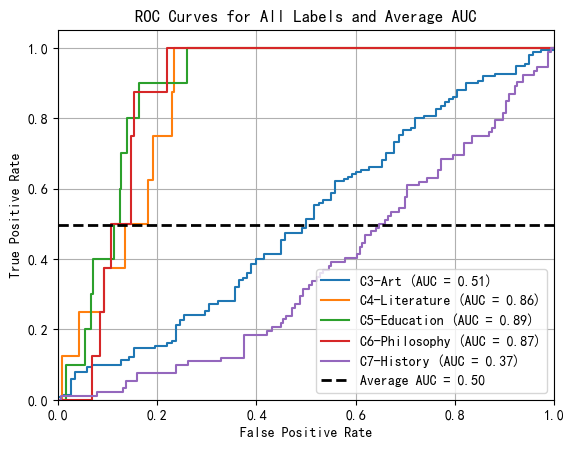

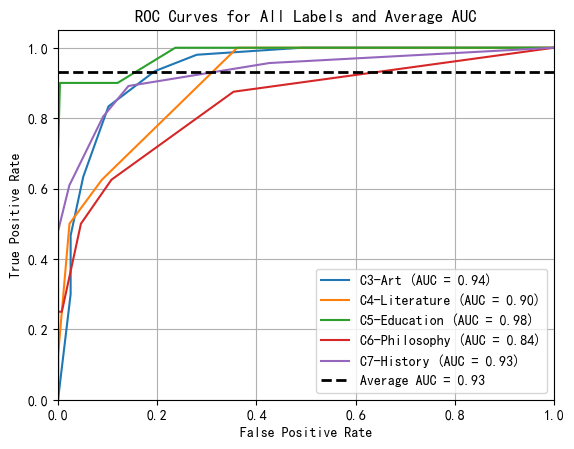

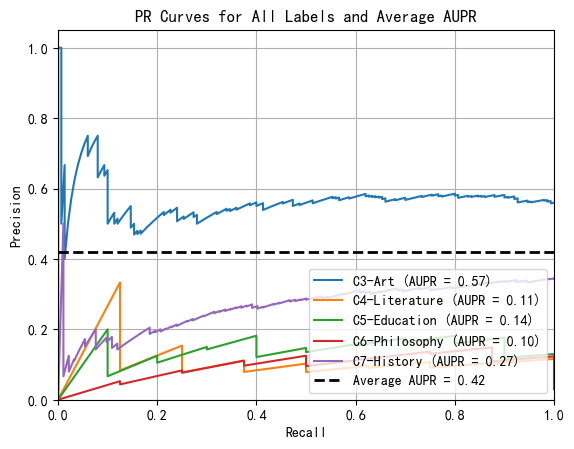

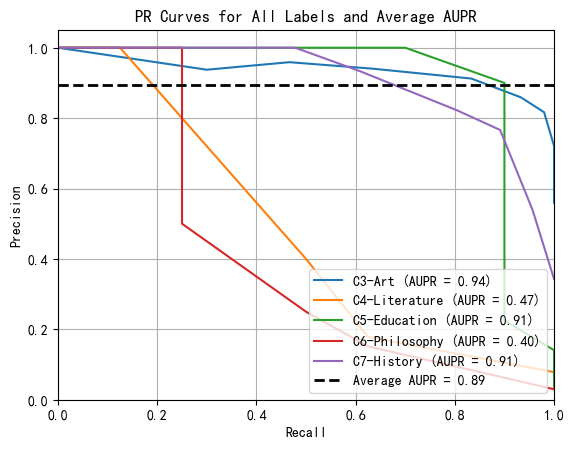

在C3-Art下的混淆矩阵:
[[ 83  35]
 [  7 143]],
精确率:0.8033707865168539,
查全率:0.9533333333333334,
F1:0.8719512195121951
在C4-Literature下的混淆矩阵:
[[260   0]
 [  8   0]],
精确率:0.0,
查全率:0.0,
F1:0.0
在C5-Education下的混淆矩阵:
[[257   1]
 [  8   2]],
精确率:0.6666666666666666,
查全率:0.2,
F1:0.3076923076923077
在C6-Philosophy下的混淆矩阵:
[[259   1]
 [  8   0]],
精确率:0.0,
查全率:0.0,
F1:0.0
在C7-History下的混淆矩阵:
[[160  16]
 [ 22  70]],
精确率:0.813953488372093,
查全率:0.7608695652173914,
F1:0.7865168539325843
加权的精确率: 0.7539403438568115, 加权的召回率: 0.8022388219833374, 加权的F1：0.7773401141166687
在C3-Art下的混淆矩阵:
[[ 84  34]
 [  6 144]],
精确率:0.8089887640449438,
查全率:0.96,
F1:0.8780487804878049
在C4-Literature下的混淆矩阵:
[[258   2]
 [  8   0]],
精确率:0.0,
查全率:0.0,
F1:0.0
在C5-Education下的混淆矩阵:
[[253   5]
 [  3   7]],
精确率:0.5833333333333334,
查全率:0.7,
F1:0.6363636363636364
在C6-Philosophy下的混淆矩阵:
[[254   6]
 [  5   3]],
精确率:0.3333333333333333,
查全率:0.375,
F1:0.35294117647058826
在C7-History下的混淆矩阵:
[[171   5]
 [ 30  62]],
精确率:0.9253731343283582,
查全率:0.6739130434782

In [20]:
# 贝叶斯算法
word_weight, label_weight= trainBN(train_txts, train_labels)
res_bn= classifyNB(test_txts, word_weight, label_weight)
class_bn= res_bn.argmax(dim= 1)
# knn算法
res_knn= classifyKNN(train_txts, train_labels, test_txts, k= 8)
class_knn= res_knn.argmax(dim= 1)
# 模型评估
print(f'朴素贝叶斯准确率: {cpt_acc(class_bn, test_labels)}')
print(f'KNN分类准确率: {cpt_acc(class_knn, test_labels)}')
draw_roc(test_labels, res_bn, folders)
draw_roc(test_labels, res_knn, folders)
draw_pr(test_labels, res_bn, folders)
draw_pr(test_labels, res_knn, folders)
cpt_prec_recall(test_labels, res_bn, folders)
cpt_prec_recall(test_labels, res_knn, folders)